In [10]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [11]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_conf = reward_conf or {}
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Search is started.
0- time: 0.03, count_rollouts: 1, reward: 0.0, node: PEPTIDE1{S.F.R.N.G.V.G.T.G.M.K.K.T.S.F.Q.R.A.K.S}$$$$
1- time: 0.16, count_rollouts: 2, reward: 0.0, node: PEPTIDE1{[ac].F.Q.S.K.G.N.V.F.V.D.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
2- time: 0.22, count_rollouts: 3, reward: 0.0, node: PEPTIDE1{[ac].S.N.W.K.W.W.P.G.I.F.D.[am]}$$$$
3- time: 0.27, count_rollouts: 4, reward: 0.0, node: PEPTIDE1{R.P.K.[dP].[dQ].[dQ].F.[dF].G.[dL].M.[am]}$$$$
4- time: 0.31, count_rollouts: 5, reward: 0.0, node: PEPTIDE1{Y.V.P.T.N.V.G.S.E.A.F}$$$$
5- time: 0.40, count_rollouts: 7, reward: 0.0, node: PEPTIDE1{F.F.K.T.L.Q.E.T.V.K.V.N}$$$$
6- time: 0.44, count_rollouts: 8, reward: 0.26377216954936145, node: PEPTIDE1{A.S.K.M}$$$$
7- time: 0.47, count_rollouts: 9, reward: 0.0, node: PEPTIDE1{T.P.R.E.R.W.R.K.K.R.G}$$$$
8- time: 0.56, count_rollouts: 11, reward: 0.0, node: PEPTIDE1{L.P.N.Y.N.W.N.S.F.G.L.R.G.[am]}$$$$
9- time: 0.60, count_rollouts: 12, reward: 0.0, node: PEPTIDE1{S.Q.E.P.P.I.S.L.D.L.T.F.H.L

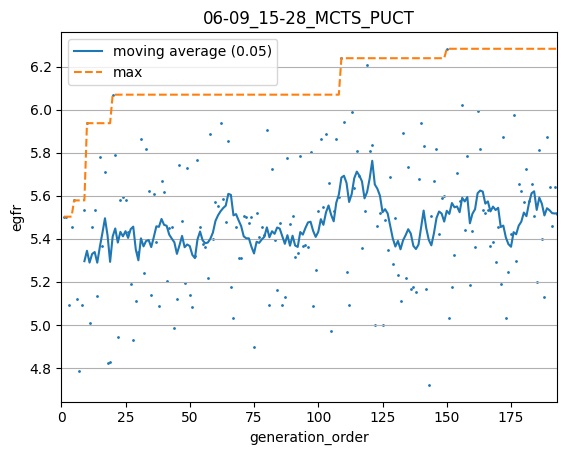

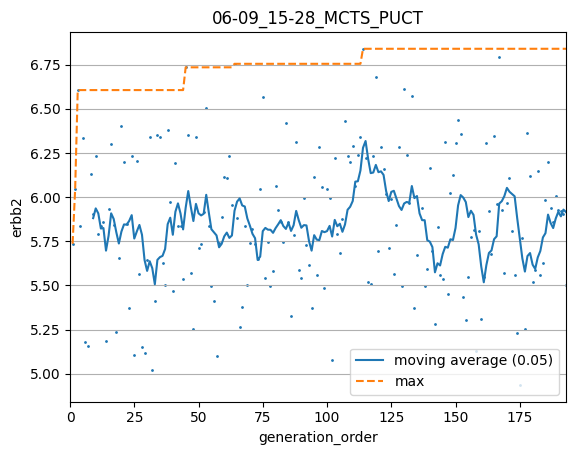

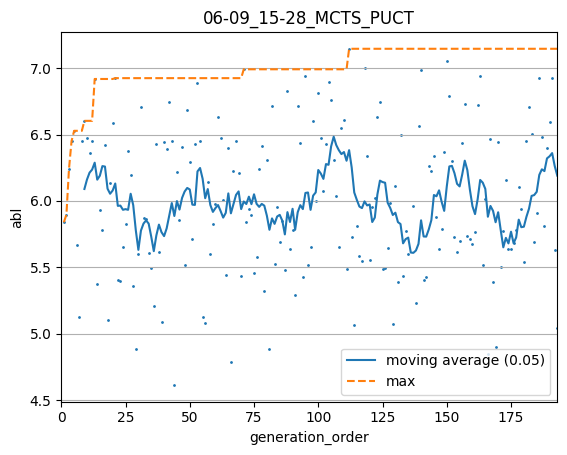

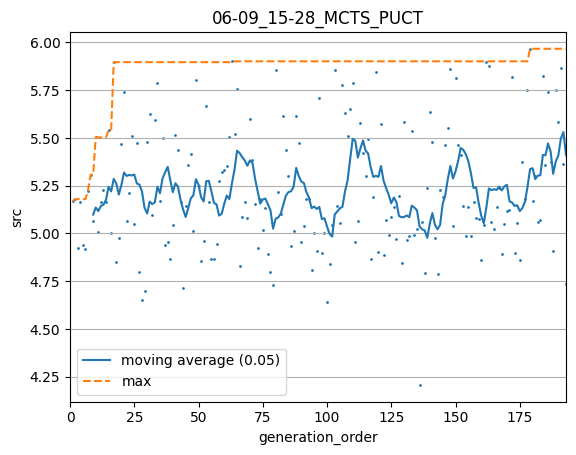

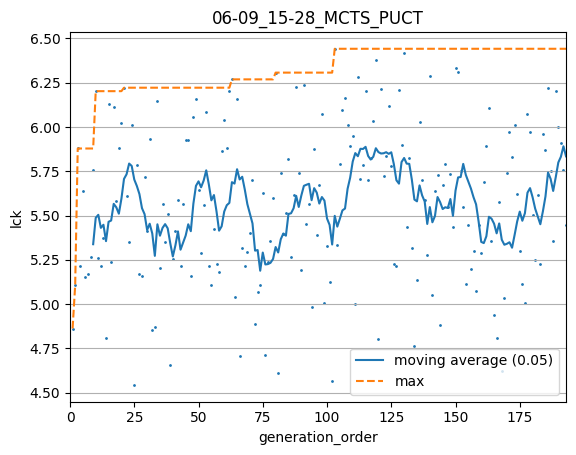

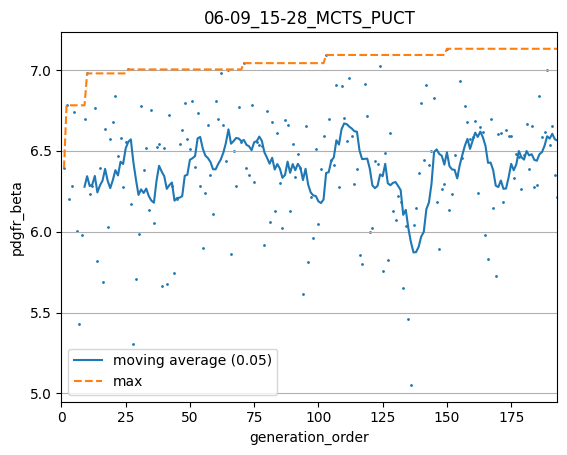

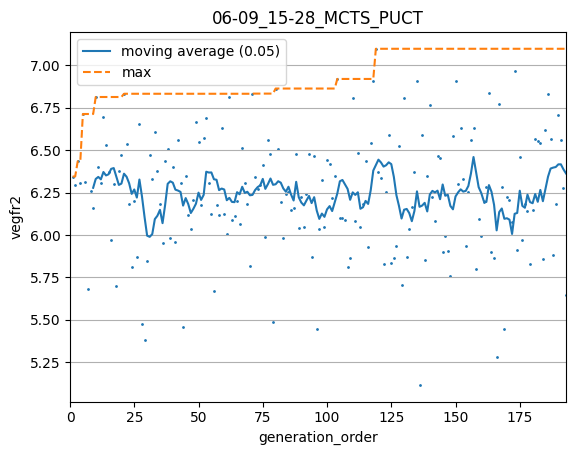

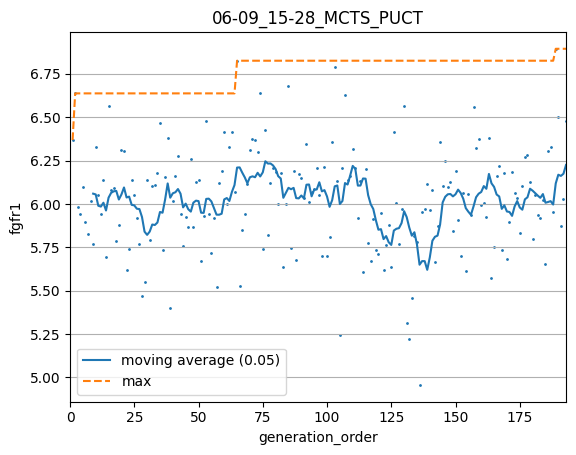

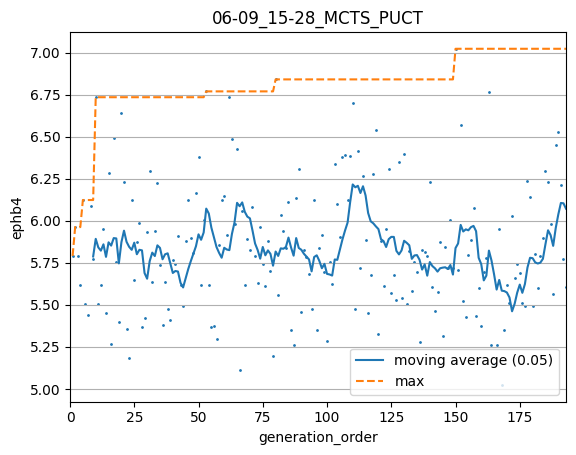

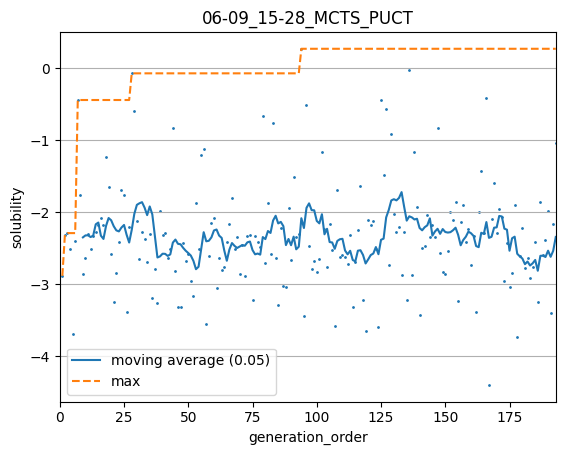

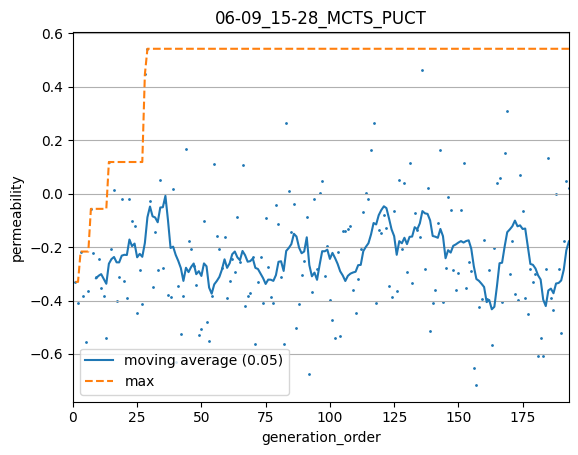

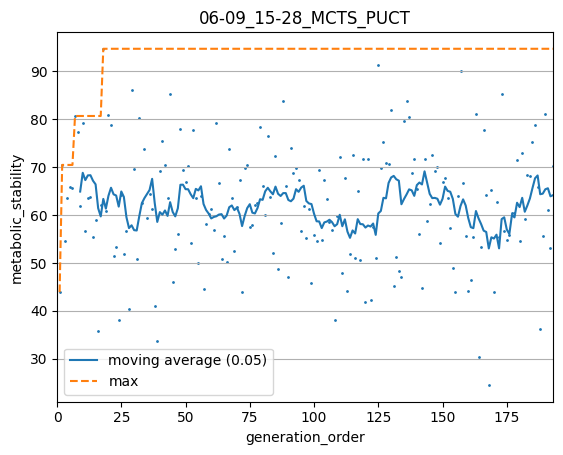

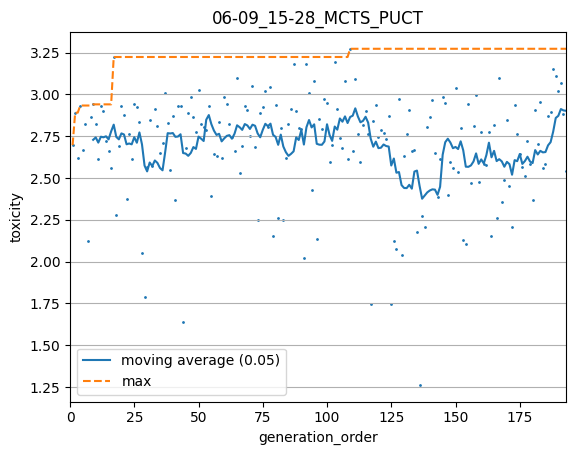

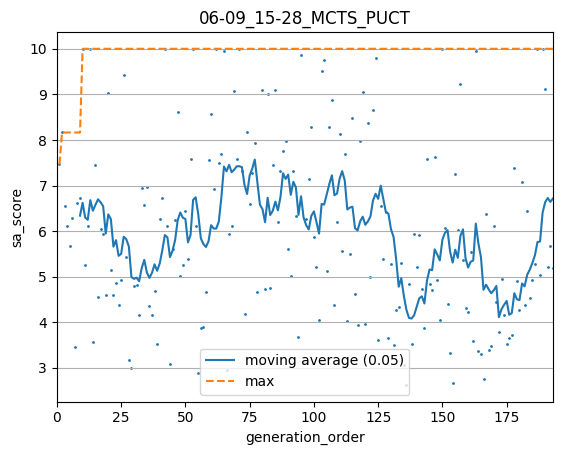

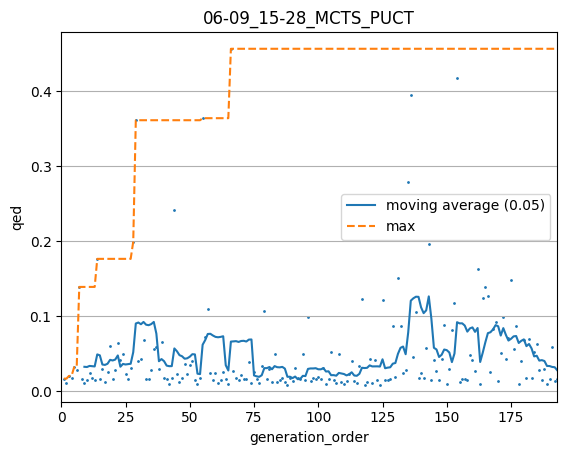

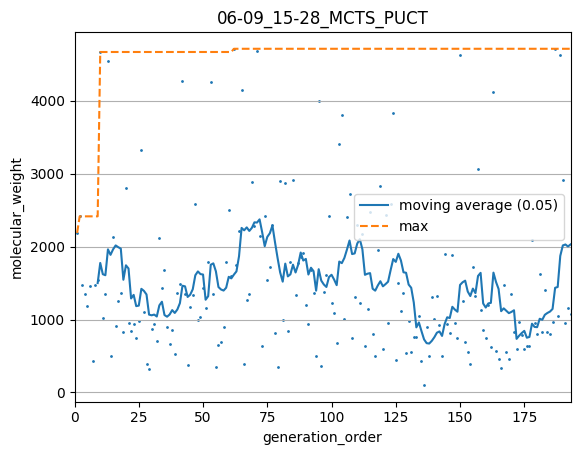

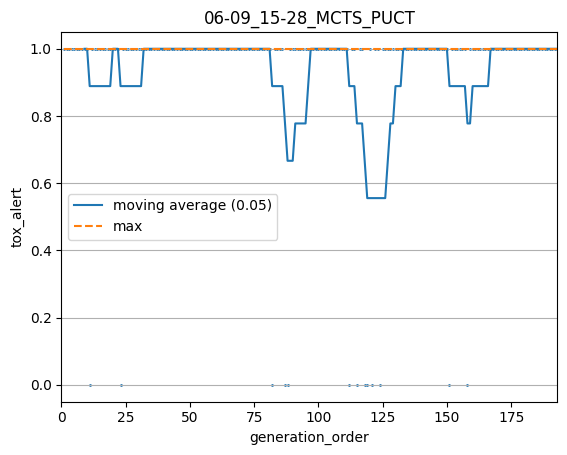

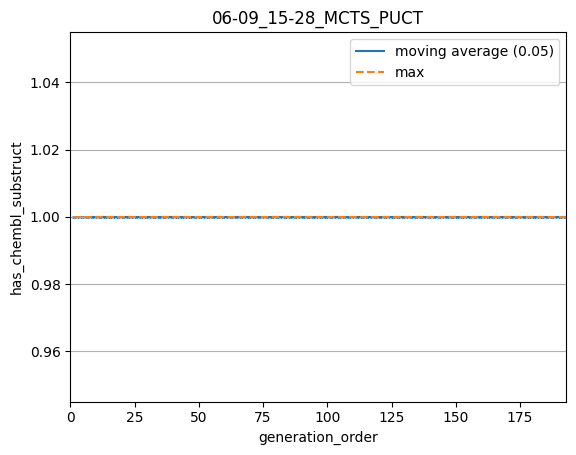

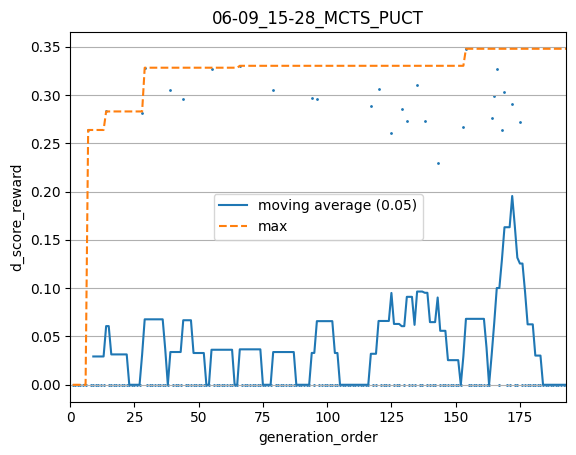

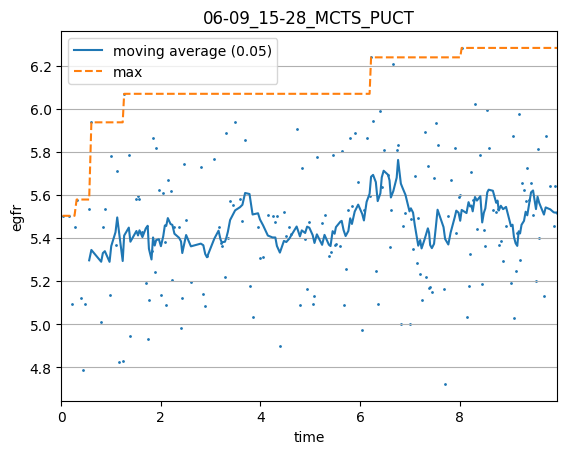

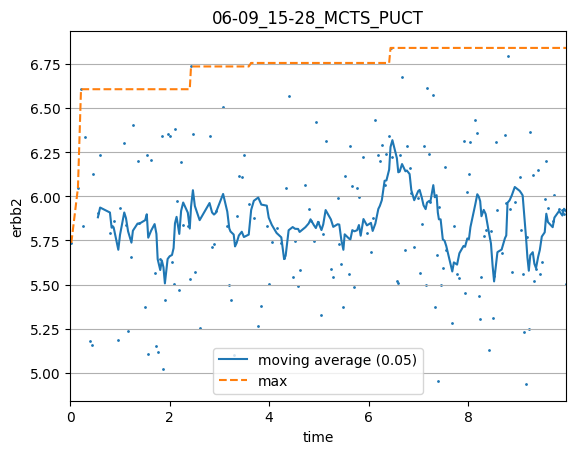

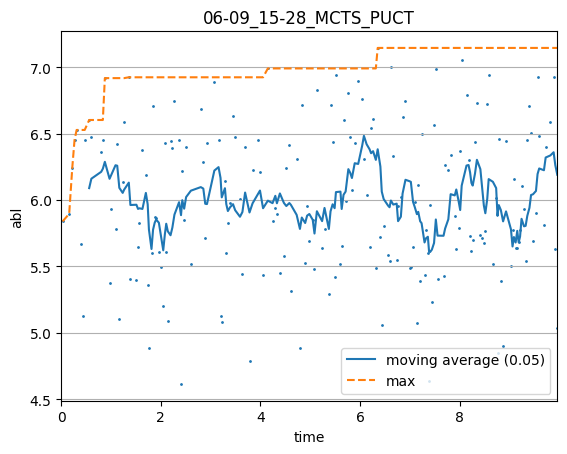

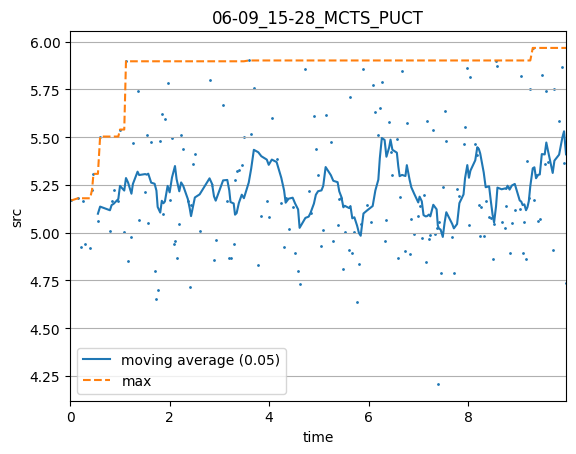

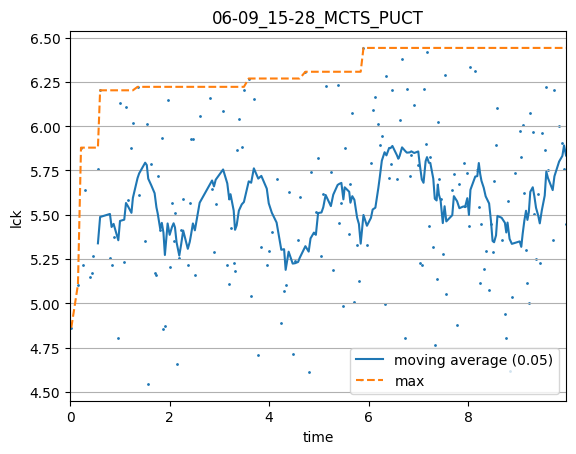

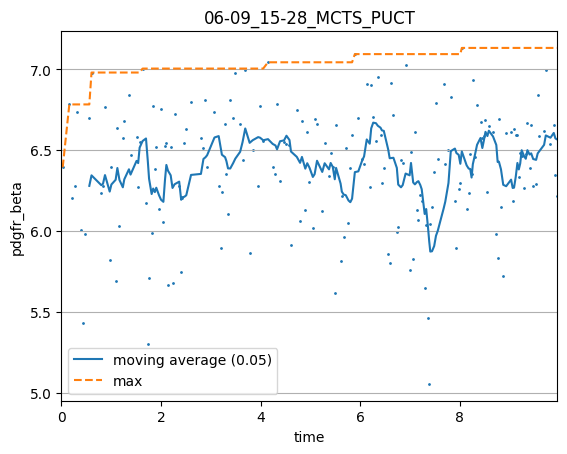

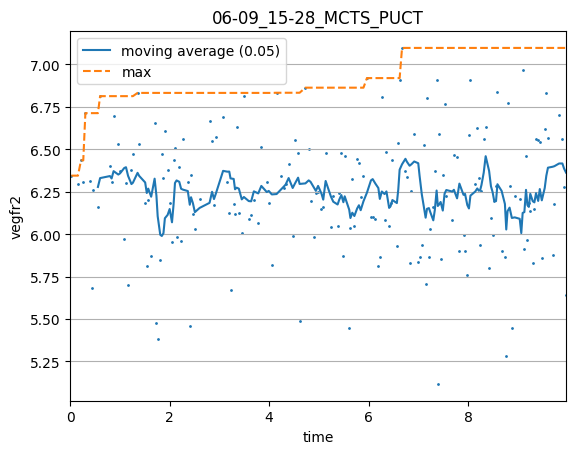

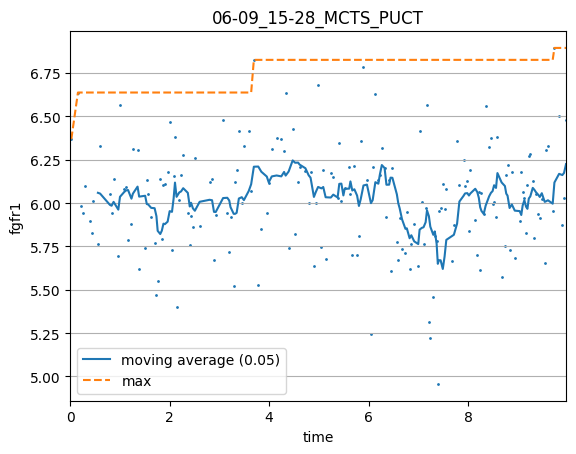

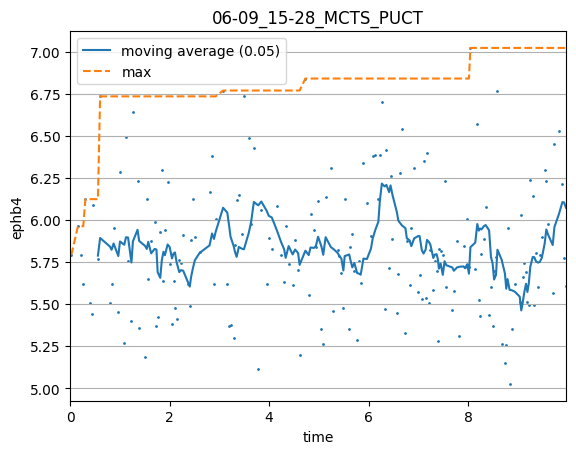

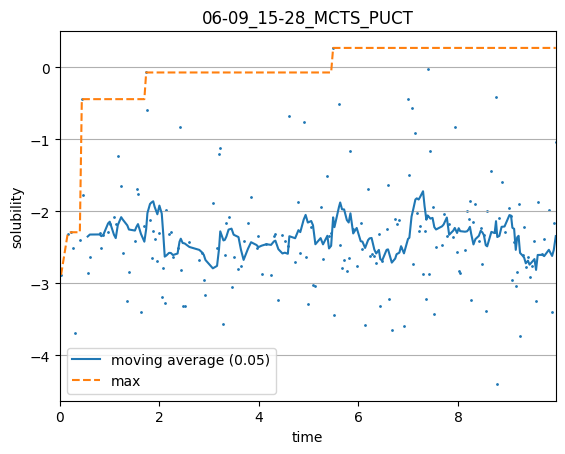

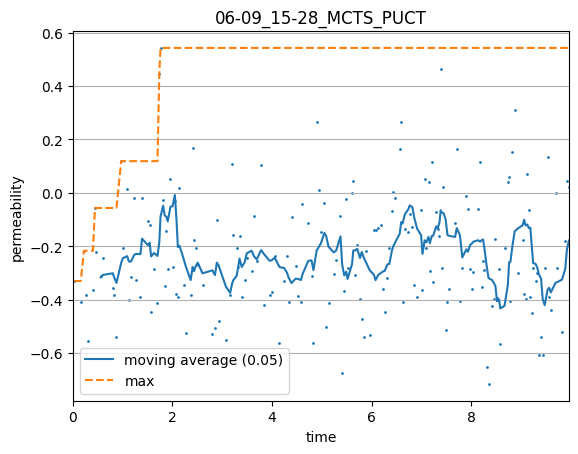

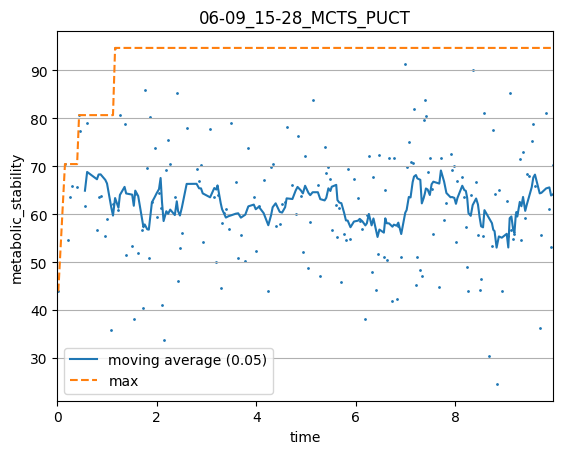

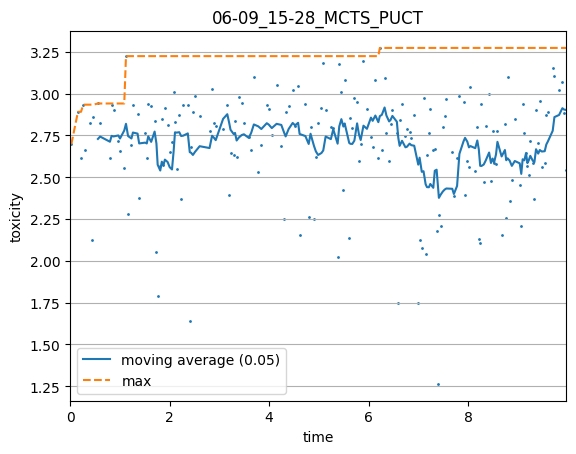

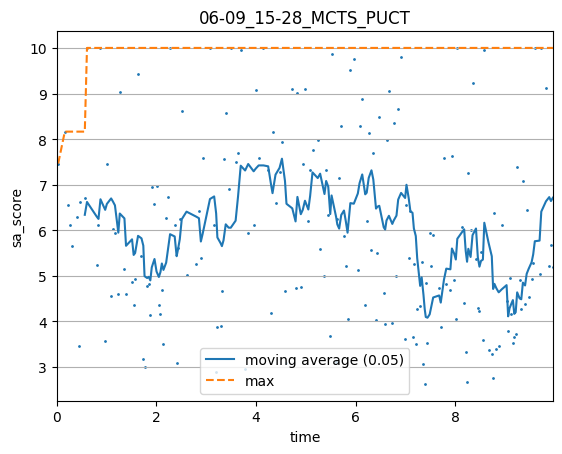

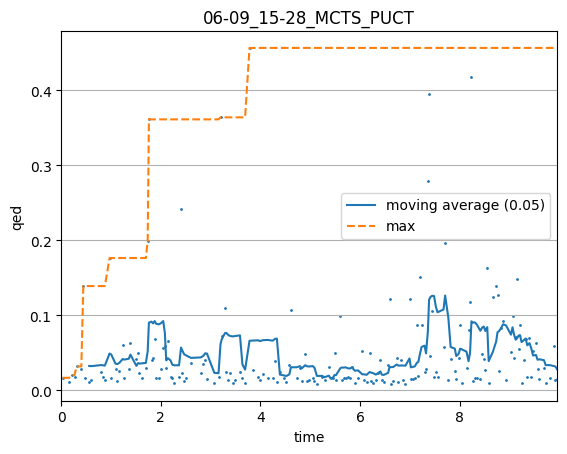

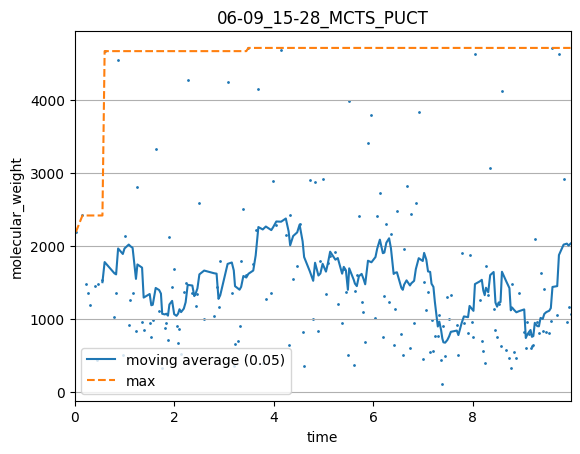

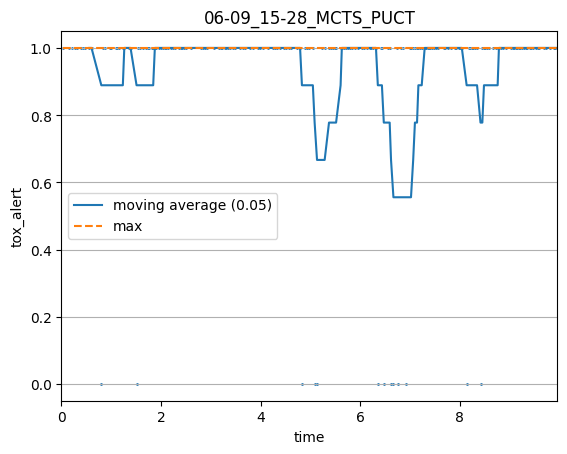

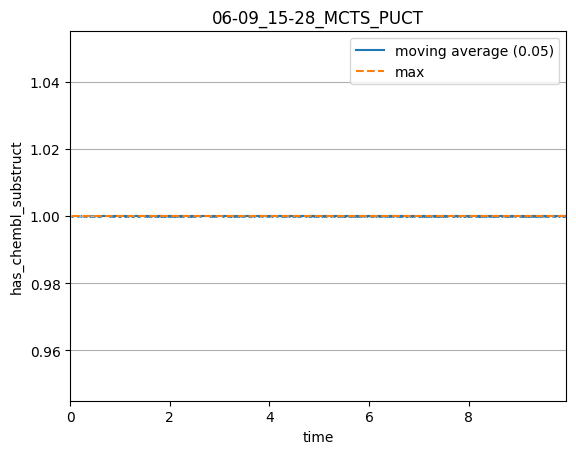

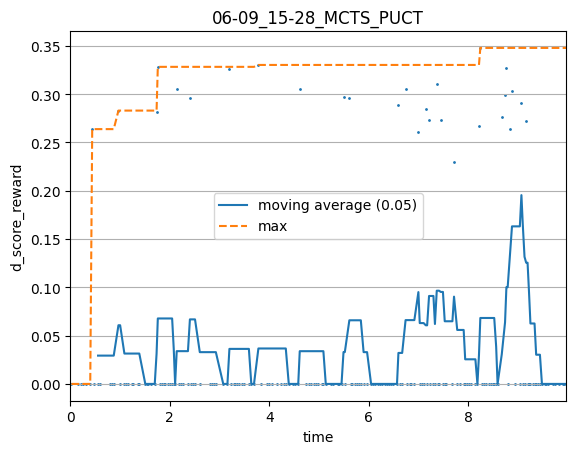

In [12]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf, filtered_reward = (conf.get(k) for k in ("output_dir", "generation_conf", "filtered_reward"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, filtered_reward=filtered_reward, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)